# Regression splines

*The following code tutorial is mainly based on the [scikit learn documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-linear-model-plot-polynomial-interpolation-py) about splines provided by Mathieu Blondel, Jake Vanderplas, Christian Lorentzen and Malte Londschien and code from [Jordi Warmenhoven](https://nbviewer.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%207.ipynb)*. To learn more about the spline regression method, review ["An Introduction to Statistical Learning"](https://www.statlearning.com/) from James et al. (2021).

- Regression splines involve dividing the range of a feature X into K distinct regions (by using so called knots). Within each region, a polynomial function is fit to the data. 

- In the following example, various piecewise polynomials are fit to the data, with one knot at age=50({cite:p}`James2021`): 

![](../_static/img/splines.png)

Figures: 

- Top Left: The cubic polynomials are unconstrained.
- Top Right: The cubic polynomials are constrained to be continuous at age=50.
- Bottom Left: The cubic polynomials are constrained to be continuous, and to
have continuous first and second derivatives. 
- Bottom Right: A linear spline is shown, which is constrained to be continuous.

- The polynomials are ususally constrained so that they join smoothly at the region boundaries, or knots. 
- Provided that the interval is divided into enough regions, this can produce an extremely flexibel fit {cite:p}`James2021`:

![](../_static/img/splines-2.png)

- A cubic spline and a natural cubic spline, with three knots. The dashed lines denote the knot locations.




- To understand the advantages of regression splines, we first start with a linear ridge regression model, build a simple polynomial regression and then proceed to splines.






## Data

### Import

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/kirenz/datasets/master/wage.csv')
df

,Unnamed: 0,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,376816,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,302281,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,10033,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,14375,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


### Create label and feature

- We only use the feature age to predict wage:

In [3]:
X = df[['age']]
y = df[['wage']]

### Data split

- Dividing data into train and test datasets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

### Data exploration

- Visualize the relationship between age and wage:

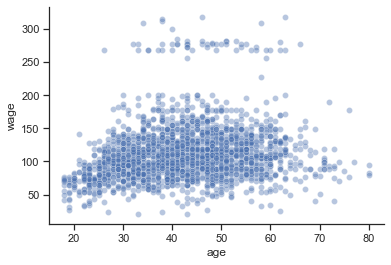

In [5]:
import seaborn as sns  

# seaborn settings
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage'], alpha=0.4);

## Ridge regression

- First, we obtain the optimal alpha parameter with cross validation
- We try different values for alpha:

In [46]:
import numpy as np

alphas=np.logspace(-6, 6, 13)
alphas

array([      0.000001,       0.00001 ,       0.0001  ,       0.001   ,
             0.01    ,       0.1     ,       1.      ,      10.      ,
           100.      ,    1000.      ,   10000.      ,  100000.      ,
       1000000.      ])

In [47]:
np.set_printoptions(suppress=True)

alphas

array([      0.000001,       0.00001 ,       0.0001  ,       0.001   ,
             0.01    ,       0.1     ,       1.      ,      10.      ,
           100.      ,    1000.      ,   10000.      ,  100000.      ,
       1000000.      ])

In [48]:
from sklearn import linear_model

reg_cv = linear_model.RidgeCV(alphas=alphas)

reg_cv.fit(X_train,y_train)

RidgeCV(alphas=array([      0.000001,       0.00001 ,       0.0001  ,       0.001   ,
             0.01    ,       0.1     ,       1.      ,      10.      ,
           100.      ,    1000.      ,   10000.      ,  100000.      ,
       1000000.      ]))

In [49]:
reg_cv.alpha_

1000.0

- Fit model with best alpha

In [50]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=reg_cv.alpha_)
reg.fit(X_train,y_train)

Ridge(alpha=1000.0)

In [51]:
print(reg.coef_)
print(reg.intercept_)

[[0.71854335]]
[80.69608773]


In [52]:
from sklearn.metrics import mean_squared_error

# create function to obtain model rmse
def model_results(model_name):

    # Training data
    pred_train = reg.predict(X_train)
    rmse_train = round(mean_squared_error(y_train, pred_train, squared=False),4)

    # Test data
    pred_test = reg.predict(X_test)
    rmse_test =round(mean_squared_error(y_test, pred_test, squared=False),4)

    # Save model results
    result = pd.DataFrame(
        {"model": model_name, 
        "rmse_train": [rmse_train], 
        "rmse_test": [rmse_test]}
        )
    
    return result;

In [53]:
model_results(model_name="ridge")

,model,rmse_train,rmse_test
0,ridge,40.7053,41.4135


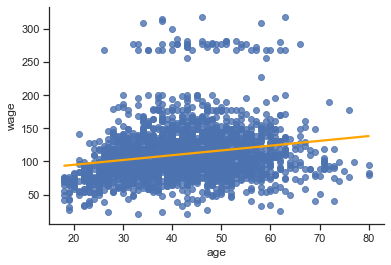

In [54]:
sns.regplot(x=X_train['age'], 
            y=y_train['wage'], 
            ci=None, 
            line_kws={"color": "orange"});

## Polynomial regression

- Next, we use a pipeline to add non-linear features to a ridge regression model.

- We use [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) which is a shorthand for the Pipeline constructor
    - It does not require, and does not permit, naming the estimators. 
    - Instead, their names will be set to the lowercase of their types automatically:

In [61]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# use polynomial features with degree 3
reg = make_pipeline(
            PolynomialFeatures(degree=3), 
            Ridge(alpha=reg_cv.alpha_)
            )

reg.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge(alpha=1000.0))])

In [62]:
model_results(model_name="poly_3")

,model,rmse_train,rmse_test
0,poly_3,39.8819,40.4427


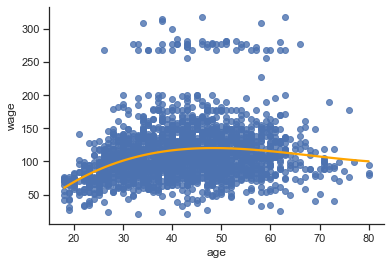

In [73]:
# plot
sns.regplot(x=X_train['age'], 
            y=y_train['wage'], 
            ci=None, 
            order=3, 
            line_kws={"color": "orange"});

## Splines 

### Splines in Scikit learn

*Note that spline transformers are a new feature in [scikit learn 1.0](https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_0_0.html). Therefore, make sure to use the latest version of scikit learn. If you use Aanconda, you can update all packages using `conda update --all`*  

- The function places the knots in a uniform (this is the default) or quantile fashion. 

- We only have to specify the desired number of knots, and then have [SplineTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html) automatically place the corresponding number of knots.

- First, we don't use Ridge regression:

In [78]:
from sklearn.preprocessing import SplineTransformer

splt = SplineTransformer(n_knots=4, degree=3)

splt.fit(X_train)
knots = splt.bsplines_[0].t


- Obtain the knots:

In [80]:
knots

array([-44.        , -23.33333333,  -2.66666667,  18.        ,
        38.66666667,  59.33333333,  80.        , 100.66666667,
       121.33333333, 142.        ])

/Users/jankirenz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(


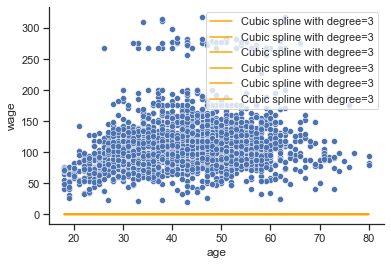

In [84]:
# Create observations
x_new = np.linspace(X_test.min(), X_test.max(), 100)
# Make some predictions
pred = splt.transform(x_new)

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage'])

plt.plot(x_new, pred, label='Cubic spline with degree=3', color='orange')
plt.legend();

In [86]:
x_new

array([[18.        ],
       [18.62626263],
       [19.25252525],
       [19.87878788],
       [20.50505051],
       [21.13131313],
       [21.75757576],
       [22.38383838],
       [23.01010101],
       [23.63636364],
       [24.26262626],
       [24.88888889],
       [25.51515152],
       [26.14141414],
       [26.76767677],
       [27.39393939],
       [28.02020202],
       [28.64646465],
       [29.27272727],
       [29.8989899 ],
       [30.52525253],
       [31.15151515],
       [31.77777778],
       [32.4040404 ],
       [33.03030303],
       [33.65656566],
       [34.28282828],
       [34.90909091],
       [35.53535354],
       [36.16161616],
       [36.78787879],
       [37.41414141],
       [38.04040404],
       [38.66666667],
       [39.29292929],
       [39.91919192],
       [40.54545455],
       [41.17171717],
       [41.7979798 ],
       [42.42424242],
       [43.05050505],
       [43.67676768],
       [44.3030303 ],
       [44.92929293],
       [45.55555556],
       [46

In [85]:
pred

array([[0.16666667, 0.66666667, 0.16666667, 0.        , 0.        ,
        0.        ],
       [0.15196965, 0.66576231, 0.18226341, 0.00000464, 0.        ,
        0.        ],
       [0.13816308, 0.66310488, 0.19869494, 0.0000371 , 0.        ,
        0.        ],
       [0.12521913, 0.65877786, 0.21587779, 0.00012522, 0.        ,
        0.        ],
       [0.11310998, 0.65286474, 0.23372847, 0.00029682, 0.        ,
        0.        ],
       [0.10180779, 0.64544898, 0.25216351, 0.00057972, 0.        ,
        0.        ],
       [0.09128475, 0.63661407, 0.27109942, 0.00100175, 0.        ,
        0.        ],
       [0.08151302, 0.6264435 , 0.29045274, 0.00159075, 0.        ,
        0.        ],
       [0.07246478, 0.61502073, 0.31013997, 0.00237453, 0.        ,
        0.        ],
       [0.0641122 , 0.60242925, 0.33007764, 0.00338092, 0.        ,
        0.        ],
       [0.05642745, 0.58875254, 0.35018226, 0.00463775, 0.        ,
        0.        ],
       [0.04938272, 0

In [74]:

# use a spline wit 4 knots and 3 degrees with a ridge regressions
reg = make_pipeline(
                    SplineTransformer(n_knots=4, degree=3), 
                    Ridge()
                    )
                     
reg.fit(X_train, y_train)

y_pred = reg.predict(X_train)

In [88]:
model_results(model_name = "spline")

,model,rmse_train,rmse_test
0,spline,39.8098,40.2801


- Obtain knots to show them in the following plot (there are degree number of additional knots each to the left and to the right of the fitted interval. These are there for technical reasons, so we refrain from showing them)

In [98]:
splt = SplineTransformer(n_knots=4, degree=3)
splt.fit(X_train)
knots = splt.bsplines_[0].t

knots[3:-3]

array([18.        , 38.66666667, 59.33333333, 80.        ])

/Users/jankirenz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(


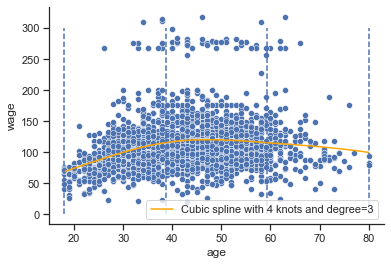

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Create observations
x_new = np.linspace(X_test.min(),X_test.max(), 100)
# Make some predictions
pred = reg.predict(x_new)

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage'])

plt.plot(x_new, pred, label='Cubic spline with 4 knots and degree=3', color='orange')
plt.vlines(knots[3:-3], ymin=0, ymax=300, linestyles="dashed")
plt.legend();

- In some settings, e.g. in time series data with seasonal effects, we expect a periodic continuation of the underlying signal. 
- Such effects can be modelled using periodic splines, which have equal function value and equal derivatives at the first and last knot. 
- Review this notebook to learn more about periodic splines in scikit learn:

- [periodic splines](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#periodic-splines)



### Splines in patsy

- Next, we use the module [patsy](https://patsy.readthedocs.io/en/latest/overview.html) to create non-linear transformations of the input data. 
- Additionaly, we use statsmodels to fit 2 models with different number of knots.

- When we fit a spline, where should we place the knots? 
- The regression spline is most flexible in regions that contain a lot of knots, because in those regions the polynomial coefficients can change rapidly. 
- Hence, one option is to place more knots in places where we feel the function might vary most rapidly, and to place fewer knots where it seems more stable. While this option can work well, in practice it is common to place knots in a uniform fashion. 
- One way to do this is to specify the desired degrees of freedom, and then have the software automatically place the corresponding number of knots at uniform quantiles of the data.

In [70]:
from patsy import dmatrix

In [71]:
# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix(
            "bs(train, knots=(25,40,60), degree=3, include_intercept=False)", 
                {"train": X_train},return_type='dataframe')

We use statsmodels to estimate a generalized linear model:

In [72]:
import statsmodels.api as sm

/Users/jankirenz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [127]:
# Fitting generalised linear model on transformed dataset
reg = sm.GLM(y_train, transformed_x).fit()

In [128]:
# Training data
pred_train = reg.predict(dmatrix("bs(train, knots=(25,40,60), include_intercept=False)", {"train": X_train}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

# Test data
pred_test = reg.predict(dmatrix("bs(test, knots=(25,40,60), include_intercept=False)", {"test": X_test}, return_type='dataframe'))
rmse_test =mean_squared_error(y_test, pred_test, squared=False)

# Save model results
model_results = pd.DataFrame(
    {
    "model": "Cubic spline (cs)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test]
    })

model_results

,model,rmse_train,rmse_test
0,Cubic spline (cs),39.726084,40.267857


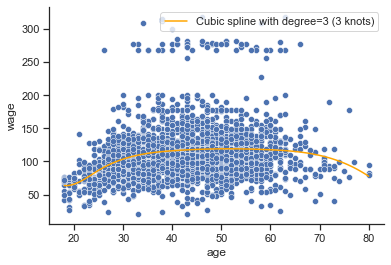

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Create observations
xp = np.linspace(X_test.min(),X_test.max(), 100)
# Make some predictions
pred = reg.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage'])

plt.plot(xp, pred, label='Cubic spline with degree=3 (3 knots)', color='orange')
plt.legend();

## Natural spline

- Finally, we fit a natural spline with patsy and statsmodels.

In [130]:
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": X_train}, return_type='dataframe')

reg = sm.GLM(y_train, transformed_x3).fit()

In [131]:
# Training data
pred_train = reg.predict(dmatrix("cr(train, df=3)", {"train": X_train}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

# Test data
pred_test = reg.predict(dmatrix("cr(test, df=3)", {"test": X_test}, return_type='dataframe'))
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

# Save model results
model_results_ns = pd.DataFrame(
    {
    "model": "Natural spline (ns)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test]
    })

model_results_ns

,model,rmse_train,rmse_test
0,Natural spline (ns),39.882574,40.325236


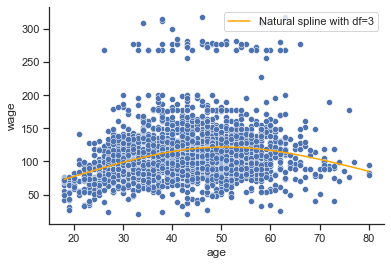

In [132]:
# Make predictions
pred = reg.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

# plot
sns.scatterplot(x=X_train['age'], y=y_train['wage'])
plt.plot(xp, pred, color='orange', label='Natural spline with df=3')
plt.legend();